# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_50', 'ORACLE.run1_8', 'ORACLE.run1_26', 'ORACLE.run1_14', 'ORACLE.run1_44', 'ORACLE.run1_38', 'ORACLE.run1_20', 'ORACLE.run1_32'}


{'ORACLE.run2_20', 'ORACLE.run2_50', 'ORACLE.run2_26', 'ORACLE.run2_38', 'ORACLE.run2_44', 'ORACLE.run2_32', 'ORACLE.run2_8', 'ORACLE.run2_14'}


tensor([[[-0.0955,  1.1942, -0.1146,  ..., -0.9840, -0.2675, -0.5732],
         [-0.6592, -0.3057,  1.0891,  ...,  0.2484, -1.4617, -0.4872]],

        [[-0.4662,  0.7090,  0.5730,  ..., -1.3014, -1.2237, -0.1165],
         [-1.1752, -0.3302,  1.1558,  ...,  0.4273, -0.1554,  1.2626]],

        [[ 0.6763, -0.3671, -0.7922,  ...,  0.8212,  1.4202,  0.3381],
         [ 0.8598,  0.7053, -0.9178,  ..., -0.7826,  0.4831, -1.1980]],

        ...,

        [[ 1.0255, -0.2498, -1.2227,  ...,  0.6639,  1.0255, -0.6771],
         [ 0.5785,  0.7428, -0.3878,  ..., -1.0123, -0.6376, -1.1701]],

        [[ 0.0260, -1.0137,  0.2924,  ...,  0.9227,  0.4808,  1.0981],
         [ 0.8122,  0.4354, -1.1631,  ..., -0.1235,  1.2996, -0.2339]],

        [[ 0.4980,  0.3408, -0.7471,  ..., -0.4718,  1.2779,  1.0616],
         [-0.4260,  1.1468, -0.0328,  ..., -1.1141, -0.0590, -0.2556]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.2242, train_label_loss: 2.9752, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3097.7698, train_label_loss: 1.2066, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3378.9223, train_label_loss: 0.7028, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3120.8508, train_label_loss: 0.6098, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2944.5528, train_label_loss: 0.7252, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3426.8345, train_label_loss: 0.7617, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3496.2147, train_label_loss: 0.5823, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3228.4346, train_label_loss: 0.3169, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2995.9251, train_label_loss: 0.7134, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2613.5108, train_label_loss: 0.4008, 


epoch: 1, source_val_acc_label: 0.6384, target_val_acc_label: 0.6283, source_val_label_loss: 50.2479, target_val_label_loss: 50.2380, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.1892, train_label_loss: 71.1804, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2694.9222, train_label_loss: 0.4903, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2653.6277, train_label_loss: 0.3579, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2661.4710, train_label_loss: 1.0303, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2918.7015, train_label_loss: 0.8005, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3032.3531, train_label_loss: 0.3773, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3411.3573, train_label_loss: 0.9030, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3278.9093, train_label_loss: 0.5715, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2902.1191, train_label_loss: 0.6734, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2626.9182, train_label_loss: 0.4504, 


epoch: 2, source_val_acc_label: 0.8188, target_val_acc_label: 0.8089, source_val_label_loss: 0.5055, target_val_label_loss: 0.5588, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.4295, train_label_loss: 0.6363, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2764.4189, train_label_loss: 0.1827, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3004.1779, train_label_loss: 0.4586, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2946.7593, train_label_loss: 0.2593, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3028.7825, train_label_loss: 0.4283, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3380.0372, train_label_loss: 0.9415, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3341.8799, train_label_loss: 0.6835, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3393.9941, train_label_loss: 0.2133, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3759.8919, train_label_loss: 0.3164, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 4042.6674, train_label_loss: 0.0990, 


epoch: 3, source_val_acc_label: 0.8543, target_val_acc_label: 0.8450, source_val_label_loss: 0.4060, target_val_label_loss: 0.4724, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.0201, train_label_loss: 0.1271, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3860.6943, train_label_loss: 0.1536, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2881.3112, train_label_loss: 0.8748, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2846.6036, train_label_loss: 0.5233, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2936.8414, train_label_loss: 0.4475, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3207.5941, train_label_loss: 0.2698, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2636.6033, train_label_loss: 0.5863, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2306.5532, train_label_loss: 0.4775, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2287.4558, train_label_loss: 0.2324, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2550.6828, train_label_loss: 0.3597, 


epoch: 4, source_val_acc_label: 0.8443, target_val_acc_label: 0.8263, source_val_label_loss: 0.4247, target_val_label_loss: 0.5090, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.6048, train_label_loss: 0.0885, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3293.5491, train_label_loss: 0.1943, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3379.5962, train_label_loss: 0.4985, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3411.7422, train_label_loss: 0.6764, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3648.9222, train_label_loss: 0.3034, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3031.9207, train_label_loss: 0.1060, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2472.0358, train_label_loss: 0.1997, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2303.8226, train_label_loss: 0.1060, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2333.5073, train_label_loss: 0.5855, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2592.2627, train_label_loss: 0.3096, 


epoch: 5, source_val_acc_label: 0.8573, target_val_acc_label: 0.8435, source_val_label_loss: 0.4001, target_val_label_loss: 0.4927, 


epoch: 6, [batch: 1 / 6720], examples_per_second: 1.9974, train_label_loss: 0.2942, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2460.5885, train_label_loss: 0.6309, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2581.5139, train_label_loss: 0.4930, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2645.8137, train_label_loss: 0.1450, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2787.2038, train_label_loss: 0.1076, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3246.7372, train_label_loss: 0.1274, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3142.8293, train_label_loss: 0.4782, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2895.2265, train_label_loss: 0.2840, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3403.8106, train_label_loss: 0.3669, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3145.3435, train_label_loss: 0.1377, 


epoch: 6, source_val_acc_label: 0.8843, target_val_acc_label: 0.8657, source_val_label_loss: 0.3239, target_val_label_loss: 0.4153, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.1017, train_label_loss: 0.0688, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2443.2292, train_label_loss: 0.4461, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2576.7472, train_label_loss: 0.1728, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2442.1515, train_label_loss: 0.3303, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2598.5250, train_label_loss: 0.4765, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2591.2822, train_label_loss: 0.6996, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3200.9043, train_label_loss: 0.1322, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2685.5083, train_label_loss: 0.2001, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2598.5187, train_label_loss: 0.2023, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2570.4065, train_label_loss: 0.1613, 


epoch: 7, source_val_acc_label: 0.8799, target_val_acc_label: 0.8600, source_val_label_loss: 0.3302, target_val_label_loss: 0.4444, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.6152, train_label_loss: 0.3750, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3001.5209, train_label_loss: 0.5207, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2987.4508, train_label_loss: 0.3621, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3019.1744, train_label_loss: 0.0820, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3395.6909, train_label_loss: 0.0524, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3330.2058, train_label_loss: 0.3420, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2510.9584, train_label_loss: 0.4997, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2483.4578, train_label_loss: 0.3127, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2358.8012, train_label_loss: 0.2214, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2448.2126, train_label_loss: 0.1730, 


epoch: 8, source_val_acc_label: 0.8988, target_val_acc_label: 0.8743, source_val_label_loss: 0.2875, target_val_label_loss: 0.4095, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.4719, train_label_loss: 0.1154, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2878.0485, train_label_loss: 0.4663, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3137.5794, train_label_loss: 0.3485, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3396.8909, train_label_loss: 0.2276, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 4028.8836, train_label_loss: 0.1392, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3524.6560, train_label_loss: 0.4642, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3036.7892, train_label_loss: 0.4059, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2519.9138, train_label_loss: 0.1852, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2343.6678, train_label_loss: 0.2340, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2548.4032, train_label_loss: 0.0413, 


epoch: 9, source_val_acc_label: 0.8964, target_val_acc_label: 0.8735, source_val_label_loss: 0.2851, target_val_label_loss: 0.5186, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.1201, train_label_loss: 0.2146, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2755.9091, train_label_loss: 0.1784, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3020.3430, train_label_loss: 0.3466, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3126.0273, train_label_loss: 0.1848, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3687.6064, train_label_loss: 0.1495, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3912.7030, train_label_loss: 0.1266, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3042.1191, train_label_loss: 0.1649, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2555.1255, train_label_loss: 0.2186, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2966.7696, train_label_loss: 0.2701, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2588.5158, train_label_loss: 0.0288, 


epoch: 10, source_val_acc_label: 0.9042, target_val_acc_label: 0.8771, source_val_label_loss: 0.2739, target_val_label_loss: 0.6228, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.4433, train_label_loss: 0.2505, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2950.8238, train_label_loss: 0.1494, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3052.7042, train_label_loss: 0.3285, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3619.9055, train_label_loss: 0.1583, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3758.7743, train_label_loss: 0.6379, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3733.7921, train_label_loss: 0.2736, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3319.2388, train_label_loss: 0.1702, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3313.6897, train_label_loss: 0.0143, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2736.0991, train_label_loss: 0.2233, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2552.1058, train_label_loss: 0.1316, 


epoch: 11, source_val_acc_label: 0.9058, target_val_acc_label: 0.8816, source_val_label_loss: 0.2690, target_val_label_loss: 0.8750, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.3697, train_label_loss: 0.3221, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2548.2186, train_label_loss: 0.4055, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2581.1470, train_label_loss: 0.0777, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2950.8975, train_label_loss: 0.2966, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3137.9621, train_label_loss: 0.0502, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2812.8619, train_label_loss: 0.1908, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2585.8834, train_label_loss: 0.1537, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2553.5476, train_label_loss: 0.0937, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2868.4686, train_label_loss: 0.0386, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3293.7110, train_label_loss: 0.1455, 


epoch: 12, source_val_acc_label: 0.9049, target_val_acc_label: 0.8790, source_val_label_loss: 0.2702, target_val_label_loss: 1.0058, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.6764, train_label_loss: 0.3652, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3916.7723, train_label_loss: 0.2264, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 4015.1432, train_label_loss: 0.0880, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 4071.4602, train_label_loss: 0.1914, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 4374.0927, train_label_loss: 0.0181, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3293.3813, train_label_loss: 0.1608, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2822.6625, train_label_loss: 0.2439, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2912.9143, train_label_loss: 0.0105, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3178.6546, train_label_loss: 0.0583, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3059.4454, train_label_loss: 0.0723, 


epoch: 13, source_val_acc_label: 0.9057, target_val_acc_label: 0.8775, source_val_label_loss: 0.2696, target_val_label_loss: 0.7549, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.7744, train_label_loss: 0.2030, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2842.7943, train_label_loss: 0.2666, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2832.9563, train_label_loss: 0.1091, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3243.9694, train_label_loss: 0.0401, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3826.7001, train_label_loss: 0.0235, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2747.9522, train_label_loss: 0.1153, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2575.7416, train_label_loss: 0.3584, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2954.4839, train_label_loss: 0.1364, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2884.8659, train_label_loss: 0.0707, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2504.8336, train_label_loss: 0.0500, 


epoch: 14, source_val_acc_label: 0.9074, target_val_acc_label: 0.8761, source_val_label_loss: 0.2642, target_val_label_loss: 0.9156, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.0147, train_label_loss: 0.1670, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2484.7747, train_label_loss: 0.0348, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2779.9326, train_label_loss: 0.1601, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2811.4881, train_label_loss: 0.1733, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3010.2602, train_label_loss: 0.1750, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2897.1857, train_label_loss: 0.0754, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2547.1061, train_label_loss: 0.1930, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2568.4240, train_label_loss: 0.0986, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2630.1797, train_label_loss: 0.0685, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2559.3594, train_label_loss: 0.0738, 


epoch: 15, source_val_acc_label: 0.9003, target_val_acc_label: 0.8688, source_val_label_loss: 0.2887, target_val_label_loss: 1.6377, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

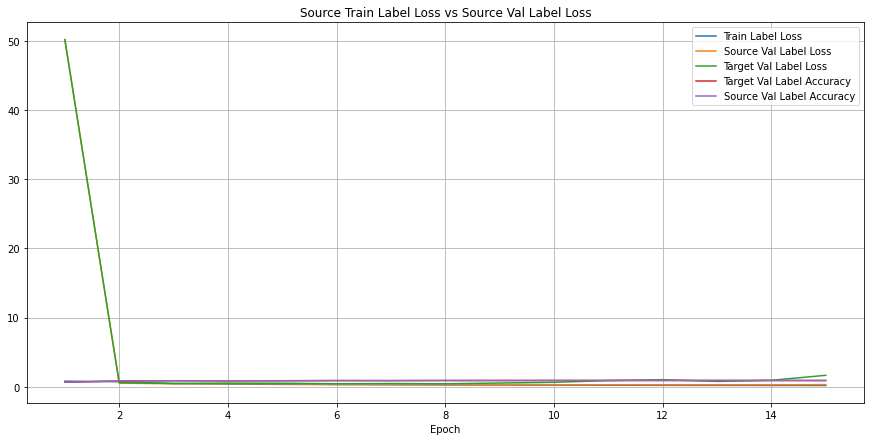

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

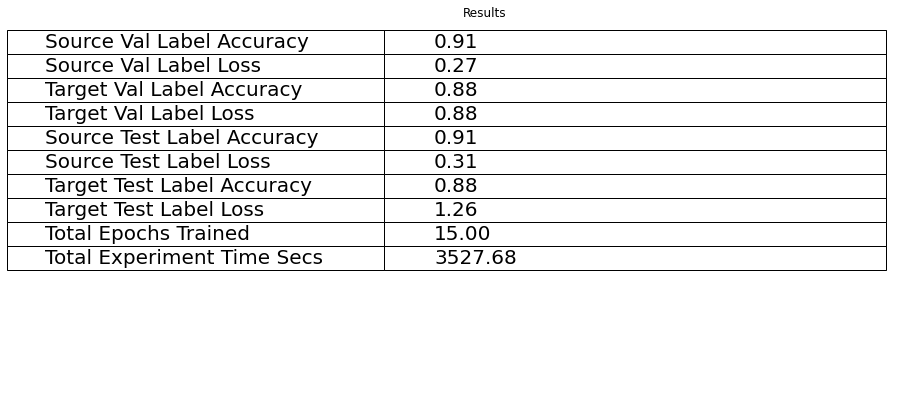

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

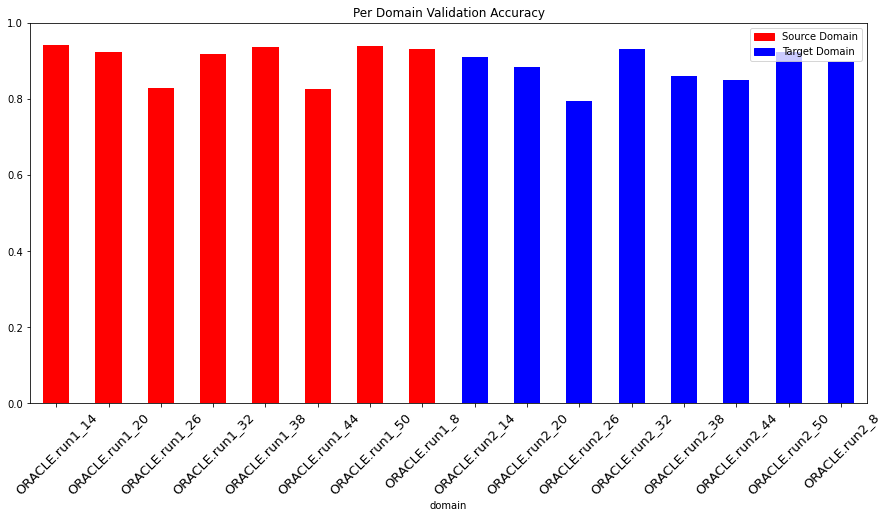

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.90625 Target Test Label Accuracy: 0.8819661458333333
Source Val Label Accuracy: 0.90576171875 Target Val Label Accuracy: 0.8815755208333333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048